In [13]:
import fceulib
import ppu_dump
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from fceu_help import pointer_to_numpy
import scipy
import scipy.misc
import cv2
import pickle
import mappy as mp
from  mappy import convert_image, Mappy
import json

In [27]:
with open("runs.json") as runsfile:
    runs = json.load(runsfile)

rom = "mario.nes"
run = runs[rom]["runs"][0]
movie = run["name"]
start_t = run["start_t"]
scroll_area = runs[rom]["scroll_area"]

mappy = Mappy(rom, movie, scroll_area, start_t, start_t+400, True)  

ep_data = {}

T: 0


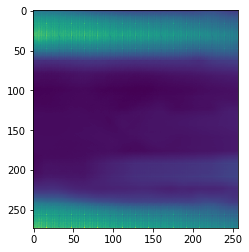

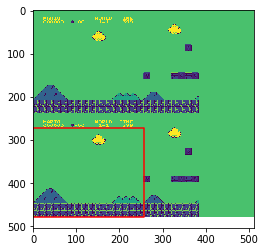

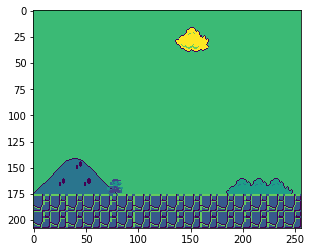

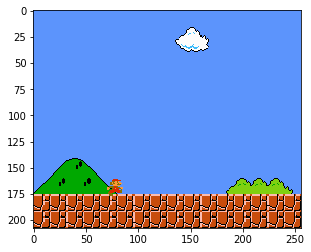

T: 60


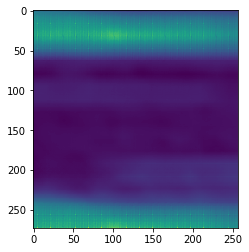

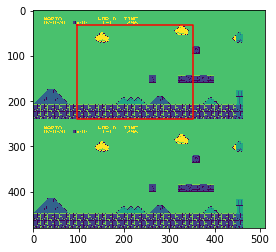

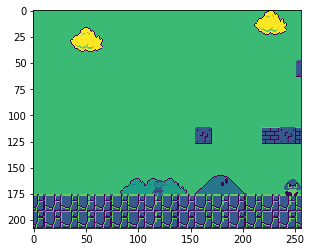

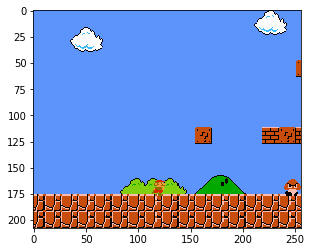

T: 120


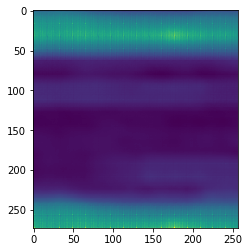

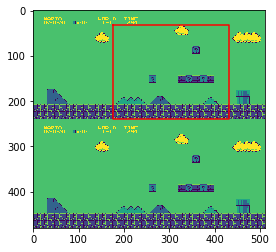

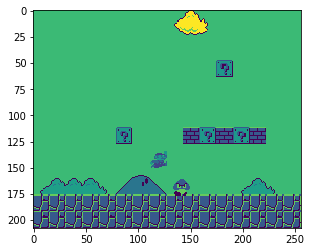

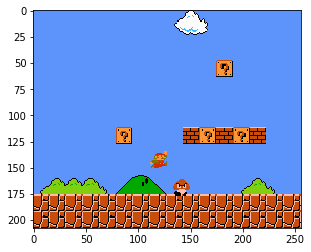

T: 180


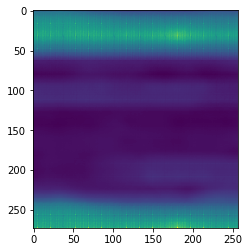

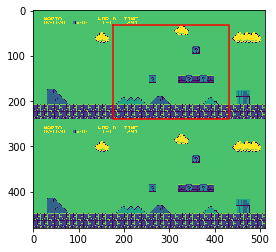

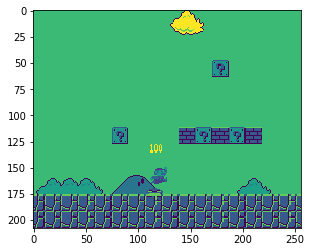

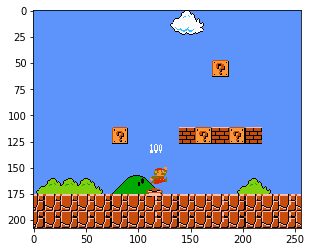

T: 240


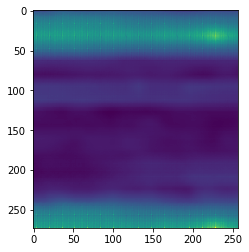

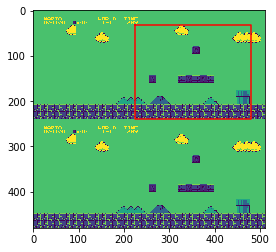

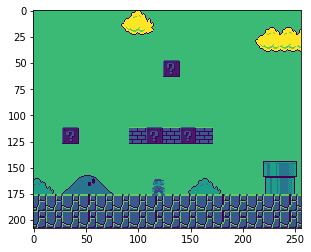

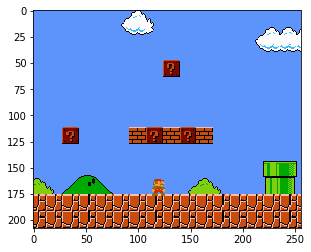

T: 300


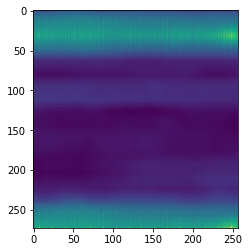

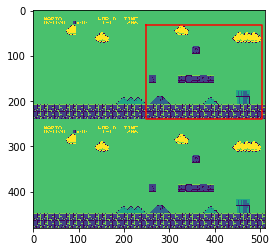

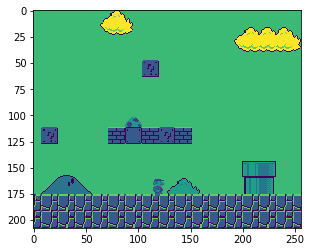

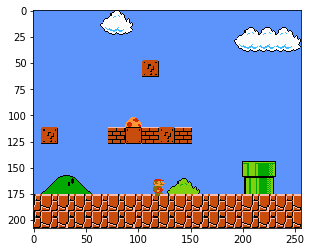

T: 360


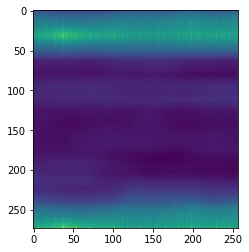

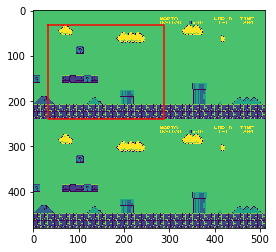

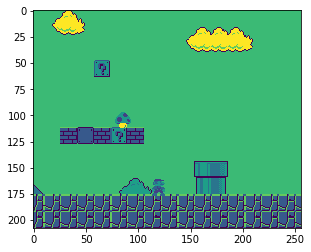

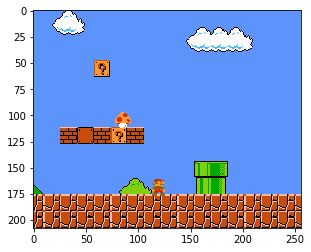

eps 400
CPU times: user 32.9 s, sys: 8.17 s, total: 41.1 s
Wall time: 26.3 s


In [28]:
%%time
global ep_data

import importlib
importlib.reload(ppu_dump)
importlib.reload(mp)
mappy.dump_run()
ep_data = mappy.ep_data
print("eps",len(ep_data["tilemap_motion"]))

In [31]:
print(len(mappy.ep_data["sprite_data"]))

400


In [30]:

mappy.map_rooms()
nt_totals = mappy.nt_totals
# todo port into mappy
room_images = []
for nt_id,nt_total in enumerate(nt_totals):
    if len(nt_total) > 0:
        minx = min(map(lambda loc: loc[1],nt_total.keys()))
        maxx = max(map(lambda loc: loc[1],nt_total.keys()))+1
        miny = min(map(lambda loc: loc[0],nt_total.keys()))
        maxy = max(map(lambda loc: loc[0],nt_total.keys()))+1
        nt_result = {}
        for x in range(minx, maxx):
            for y in range(miny, maxy):
                if (y,x) in nt_total:
                    nt_result[y-miny, x-minx] = nt_total[(y, x)]
        colorized = ep_data["tile2colorized"]
        out_image = np.zeros(shape=((maxy-miny)*8, (maxx-minx)*8, 4))
        for x in range(0, maxx-minx):
            for y in range(0, maxy-miny):
                col = np.zeros(shape=(8,8,3))
                if (y,x) in nt_result:
                    ind_per_tile = nt_result[y,x].values()
                    i2c = {}
                    for i in ind_per_tile:
                        if i not in i2c:
                            i2c[i] = 0
                        i2c[i] += 1
                    
                    #ind = sorted(nt_result[y, x])

                    #ind = ind[int(len(ind)/4.0)]
                    col = colorized[sorted(i2c.items(), key=lambda entry: (entry[1],entry[0]))[-1][0]]  # Returns the highest occurring item
                    
                    #col = colorized[nt_result[y, x][ind]]
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, :3] = col/255.
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, 3] = 1.0
        plt.figure(figsize=(20,10)) 
        plt.imshow(out_image)
        room_images.append((out_image,(0,(maxx-minx)*8,0,(maxy-miny)*8)))
        plt.savefig('{}.png'.format(nt_id))
        plt.show()

NameError: name 'ep_data' is not defined

In [ ]:
# %%time
import tracking
importlib.reload(tracking)


global tracks
global old_tracks
tracks, old_tracks = tracking.tracks_from_sprite_data(ep_data['sprite_data'],sigma=5,min_gate=5)
for track in tracks:
    old_tracks.append((track,tracks[track]))
  

In [ ]:
world_space_tracks = []
for track in old_tracks[:]:
    for t in sorted(track[1]):
        room_ids = {}
        most_seen = -1
        most_times_seen = -1
        
        if t in screen_offsets:
            room_id = room_v_time[t]  
            if room_id not in room_ids:
                room_ids[room_id] = 0
            room_ids[room_id] += 1
            if room_ids[room_id] > most_times_seen:
                most_times_seen = room_ids[room_id]
                most_seen = room_id
                
    world_space_track = {}
    for t in sorted(track[1]):
        if t in screen_offsets:
            current_offset = np.array(screen_offsets[t]-np.array(room_starts[most_seen]))
            
            #room_id = room_v_time[t]  
            #print( t,room_id)
            #print( track[1][t][0],screen_offsets[t]np.array(room_starts[most_seen]))
            
            point =  track[1][t][0]+current_offset
            bb = track[1][t][1]            
            bb = (bb[0]+current_offset[0],bb[1]+current_offset[1],
                               bb[2]+current_offset[0],bb[3]+current_offset[0],
                               bb[4]+current_offset[1],bb[5]+current_offset[1],
                               bb[6],bb[7])
            
            sprites = track[1][t][2]
            modified_sprites = []
            for sprite in sprites:
                loc = np.array(sprite[1][:2])
                corner = np.array((track[1][t][1][2],track[1][t][1][4]))
                
                modified_sprites.append((sprite[0], corner-loc))
            
            world_space_track[t] = (point,bb, modified_sprites)
    world_space_tracks.append((track[0],world_space_track))

In [ ]:
ind = 0
for track in sorted(old_tracks):
    ind +=1
    print( track[0])
    pts = []
    print( sorted(track[1])[0],sorted(track[1])[-1])
    room_ids = {}
    for t in sorted(track[1]):
        most_seen = -1
        most_times_seen = -1
        
        if t in screen_offsets:
            room_id = room_v_time[t]  
            if room_id not in room_ids:
                room_ids[room_id] = 0
            room_ids[room_id] += 1
            if room_ids[room_id] > most_times_seen:
                most_times_seen = room_ids[room_id]
                most_seen = room_id
    offset = np.array([0.5,0.5])
    actual_track = []
    for most_seen in room_ids:
        pts = []
        for t in sorted(track[1]):
            if t in screen_offsets:
                #room_id = room_v_time[t]  
                #print( t,room_id)
                #print( track[1][t][0],screen_offsets[t]np.array(room_starts[most_seen]))
                pts.append(track[1][t][0]+np.array(screen_offsets[t]-np.array(room_starts[most_seen])))
                actual_track.append(pts)
                bounding_box = track[1][t][1]
                half_extent = np.array(bounding_box[-2:])/2.0
                if False:
                    pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))-half_extent)
                    pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))+half_extent*np.array([-1,1]))
                    pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))+half_extent)
                    pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))+half_extent*np.array([1,-1]))
                    pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))-half_extent)
                pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen])))

        pts = np.array(pts)
        plt.figure(figsize=(20,10)) 
        plt.imshow(room_images[most_seen][0],origin='upper')
        plt.plot(pts[:,0],scroll_area[3]*8-pts[:,1],'w')
        plt.axis([room_images[room_id][1][0],room_images[room_id][1][1],room_images[most_seen][1][3],room_images[most_seen][1][2]])
        plt.show()

    plt.figure(figsize=(20,10)) 
    plt.plot(pts[:,0],scroll_area[3]*8-pts[:,1])
    plt.show()

In [ ]:
import pickle

pickle.dump(world_space_tracks,open('all_tracks.pkl','wb'))

In [ ]:
import random

def encode(input_string):
    count = 1
    prev = ''
    lst = []
    for character in input_string:
        if character != prev:
            if prev != '':
                entry = (prev,count)
                lst.append(entry)
                #print( lst)
            count = 1
            prev = character
        else:
            count += 1
    else:
        entry = (character,count)
        lst.append(entry)
    return lst



def circular_match(A,B):

    
    a = len(A)
    b = len(B)
    str1 = ' '.join(map(str, A))
    str2 = ' '.join(map(str, B))
    
    ratio = int(float(a)/float(b))+1
    ratio2 = int(float(b)/float(a))+1
    return str1 in ' '.join([str2]*ratio) and str2 in ' '.join([str1]*ratio2) 


def repeat(s):
    prefix_array=[]
    for i in range(1,int(len(s)//2)+1):
        prefix_array.append(s[:i])
    #see what it holds to give you a better picture
    for i in prefix_array:
        if len(s) % len(i) == 0:
            if i*(len(s)//len(i)) == s:
                return i,(len(s)//len(i))

    return s,1

def get_cycles(trace,split):
    index = 0
    new_trace = []
    cycles = {}
    new_split = []
    for s in split:    
        cycle = tuple(trace[index:index+s])
        cycle, repetitions= repeat(cycle)    
        
        index += s
        if cycle not in cycles:
            cycles[cycle] = len(cycles)
        new_trace += [cycles[cycle]]*repetitions
        new_split += [len(cycle)]*repetitions
        
        
    id2cycle = {i:v for v,i in cycles.items()}
    subsets = {}
    
    for cycle1 in sorted(cycles,key=len,reverse=False):
        subsets[cycle1] = []
        for cycle2 in sorted(cycles,key=len,reverse=False): 
            if circular_match(cycle2,cycle1) and len(cycle1) == len(cycle2):
                subsets[cycle1].append(cycle2)
                   
    count2cycle = {}
    for cycle in subsets:
        if len(subsets[cycle]) not in count2cycle:
            count2cycle[len(subsets[cycle])] = []
        count2cycle[len(subsets[cycle])].append(cycle)
    best_subset = {}
    temp = 0 
    while len(count2cycle) > 0:
        temp += 1
        most_covered = sorted(count2cycle,reverse=True)[0]
        shortest_length = float('inf')
        
        for cycle in count2cycle[most_covered]:
            if len(cycle) < shortest_length:
                shortest_length = len(cycle)
                shortest = cycle
        covered = [shortest] + subsets[shortest]
        for c in covered:
            best_subset[c] = shortest
        empty = []
        for c in count2cycle:
            for cov in covered:
                if cov in count2cycle[c]:
                    count2cycle[c].remove(cov)
            if len(count2cycle[c]) == 0:
                empty.append(c)
        for e in empty:
            del count2cycle[e]
            
    return cycles,new_trace,best_subset,new_split


In [ ]:
from functools import reduce

def score(trace,split):
    new_split = []
    index = 0
    for s in split:
        cur_index = 0        
        for t in trace[index:index+s]:
            if t == 'NA':
                if cur_index >= 1:
                    new_split.append(cur_index)
                new_split.append(1)
                cur_index = 0
            else:
                cur_index += 1
        if cur_index > 0:
            new_split.append(cur_index)
        index += s
    
    cycles,new_trace,subsets,new_split = get_cycles(trace,new_split)
    rle_encoded  = encode(new_trace)
    size = 0
    seen = set()
    for s in cycles:
        if subsets[s] not in seen:
            seen.add(subsets[s])
            size += len(subsets[s])
    id2cycle = {v:k for k,v in cycles.items()}
    for cycle_id in new_trace:    
        cycle1 = id2cycle[cycle_id]
        if cycle1 in subsets:
            cycle2 = subsets[cycle1]
            match = circular_match(cycle1,cycle2)
            if cycle1 != cycle2:
                if  len(cycle1) != len(cycle2):
                    size += 1
                size += 1
    
    return size*np.log(len(trace)/2.0)+len(rle_encoded),rle_encoded,subsets,new_split
        
def mutate(split,trace):
    cycles,new_trace,subsets,new_split = get_cycles(trace,split)
    counts = {}
    for t in new_trace:
        
        if t not in counts:
            counts[t] = 0.0
        counts[t] += 1.0
    split = new_split
    
    inv_count = {t:(1.0/counts[t])**3.0 for t in counts}
    
    total = np.sum([inv_count[t] for t in new_trace])
    #for t in new_trace:
    #    print( t, inv_count[t])
    
    split_id = 0
    split_val = random.random()*total
    for t in new_trace:
        split_val -= inv_count[t]
        if split_val <= 0:
            break
        split_id += 1
    
    
    #split_id = random.randint(0,len(split)-1)
    new_split = [s for s in split]
    if random.random() < 0.5 and split[split_id] > 1:
        split_left = split[split_id]
        split_right = random.randint(1,split_left)
        split_left -= split_right
        if not (split_left == 0 or split_right == 0):
            new_split = new_split[:split_id] + [split_left,split_right] + new_split[split_id+1:]
    elif random.random() < 0.5 and  split_id != 0:
        new_split =  new_split[:split_id-1] + [ new_split[split_id-1]+new_split[split_id]] + new_split[split_id+1:]
    elif random.random() < 0.5 and  split_id < len(new_split)-1:
        new_split =  new_split[:split_id] + [ new_split[split_id]+ new_split[split_id+1]] + new_split[split_id+2:]
    return new_split

def crossover(split_left,split_right):
    
    sum = reduce(lambda x,y:x+y,split_left)
    if sum == 1:
        return split_left, split_right
    crossover_point = random.randint(1,sum-1)
    running_total = 0
    left_left = []
    left_right = []
    for left_point in range(len(split_left)):
        running_total += split_left[left_point]
        if running_total >= crossover_point:
            left_carry_over = running_total-crossover_point
            if left_carry_over == 0:
                left_left.append(split_left[left_point])
                left_right = split_left[left_point+1:]
            else:
                left_left.append(split_left[left_point]-left_carry_over)
                left_right = [left_carry_over]+split_left[left_point+1:]
            break
        left_left.append(split_left[left_point])
    right_left = []
    right_right = []
    running_total = 0
    for right_point in range(len(split_right)):
        running_total += split_right[right_point]
        if running_total >= crossover_point:
            right_carry_over = running_total-crossover_point
            if right_carry_over == 0:
                right_left.append(split_right[right_point])
                right_right = split_right[right_point+1:]
            else:
                right_left.append(split_right[right_point]-right_carry_over)
                right_right = [right_carry_over]+split_right[right_point+1:]
            break
        right_left.append(split_right[right_point])
    return left_left + right_right, right_left + left_right


In [ ]:
def find_animations(raw_data,population_size = 300,generations=300,tournament_prob=0.15,proportion_to_keep=0.15,mutation_count=8,crossover_amount=0.1,population=None,early_terminate=10):
    selection = 'Tournament'
    data = [e[0] for e in raw_data]
    keep_each = int(proportion_to_keep*population_size)
    crossover_amount = int(population_size*crossover_amount)
    best_score = float('inf')
    
    if not population:
        print( 'new population')
        population = []
        for ii in range(population_size):
            splits = random.randint(int(len(data)*0.5),len(data))
            split = [len(data)]
            for jj in range(splits):
                split_id = random.randint(0,len(split)-1)
                split_left = split[split_id]
                split_right = random.randint(1,split_left)
                split_left -= split_right
                if not (split_left == 0 or split_right == 0):
                    split = split[:split_id] + [split_left,split_right] + split[split_id+1:]
            population.append(split)
    def score_population(population):
        scored = {}
        for split_id in range(len(population)): 
            split = population[split_id]
            current,encoded,_,split = score(data,split)
            population[split_id] = split
            if current not in scored:
                scored[current] = []
            scored[current].append(split)
        return scored
    generations_since_improvement = 0
    previous_best_score = float('inf')
    for generation in range(generations):
        print( 'generation', generation)
        current_population = []
        scored = score_population(population)
        best_score = list(sorted(scored))[0]
        print( best_score, previous_best_score)
        if best_score != previous_best_score:
            generations_since_improvement = 0
            previous_best_score = best_score
        else:
            generations_since_improvement +=1
            if generations_since_improvement >= early_terminate:
                break
            
        if selection == 'FitnessProportionate':
            scores = []
            for s in sorted(scored):
                current_population += scored[s]
                scores += [s]*len(scored[s])

            total = 0
            for i,s in enumerate(scores):
                scores[i] = np.exp(-s/2.0)
                total += scores[i]
            for i,s in enumerate(scores):
                scores[i] /= total

            #print( scores)
            new_population = []
            for ii in range(keep_each):
                rv = random.random()
                for s,member in zip(scores,current_population):
                    rv -= s
                    if rv < 0:
                        new_population.append([c for c in member])
                        break
        else:
            new_population = []
            for s in sorted(scored):
                current_population += scored[s]
                
            for ii in range(keep_each):
                for member in current_population:
                    if random.random() < tournament_prob:
                        new_population.append(member)
                        break
            
        current_population = new_population
        
        #current_population = current_population[:keep_each]
        while len(current_population) != population_size:
            mutated = random.choice(current_population)
            for ii in range(mutation_count):
                mutated = mutate(mutated,data)
            current_population.append(mutated)
        for ii in range(crossover_amount):
            id1 = random.randint(0,population_size-1)
            id2 = random.randint(0,population_size-1)
            new1,new2 = crossover(population[id1],population[id2])
            population[id1] = new1
            population[id2] = new2
        population = current_population
    scored = score_population(population)
    best_score = list(sorted(scored))[0]
    best_split = scored[best_score][0]
    cycles,new_trace,subsets,new_split = get_cycles(data,best_split)
    
    id2cycle = {v:k for k,v in cycles.items()}
    previous_cycle_id = -1
    animations = []
    animation_ids = []
    times_seen = {}
    for cycle_id in new_trace:
        if cycle_id not in times_seen:
            times_seen[cycle_id] = 0
        times_seen[cycle_id] += 1
    for cycle_id in new_trace:    
        cycle1 = id2cycle[cycle_id]
        if cycle1 in subsets:
            cycle2 = subsets[cycle1]
            animation_ids.append((cycles[cycle2],0,len(cycle2)))
        else:
            animation_ids.append((cycle_id,0,len(cycle1)))
        animations.append(cycle1)   
    
    raw_id = 0
    time_animations = []
    for animation in animations:
        time_animation = []
        time_animations.append(time_animation)
        for frame in animation:
            time_in_frame = raw_data[raw_id][1]
            time_animation.append((frame,time_in_frame))
            raw_id += 1
    
    
    return animation_ids, animations,time_animations,id2cycle,population



In [ ]:
time_split = 30
animation_maps = []
color_ids = {}
tiles_expanded = {}
for nt_id,nt_total in enumerate(nt_totals):
    if len(nt_total) > 0:
        minx = min(map(lambda loc: loc[1],nt_total.keys()))
        maxx = max(map(lambda loc: loc[1],nt_total.keys()))+1
        miny = min(map(lambda loc: loc[0],nt_total.keys()))
        maxy = max(map(lambda loc: loc[0],nt_total.keys()))+1
        nt_result = {}
        animation_maps.append(nt_result)
        for y in range(miny, maxy):
            for x in range(minx, maxx):
                if (y,x) in nt_total:                    
                    offset_y = y-miny
                    offset_x = x-minx
                    nt_result[offset_y, offset_x] = nt_total[(y, x)]
                    
                    ids = [nt_result[offset_y, offset_x][t] for t in sorted(nt_result[offset_y, offset_x])]
                    colors = [tuple(colorized[d].ravel()) for d in ids]
                    for c in colors:
                        if c not in color_ids:
                            color_ids[c] = len(color_ids)
                    colors = [color_ids[c] for c in colors]
                    times = sorted(nt_result[offset_y, offset_x])
                   
                    encoding = encode(colors)
                    expanded_encoding = []

                    for e in encoding:
                        time = e[1]
                        while time > 0:
                            if time < time_split:
                                expanded_encoding.append((e[0],time))
                            else:
                                expanded_encoding.append((e[0],time_split))
                            time -= time_split
                    tiles_expanded[offset_y,offset_x] = (times,expanded_encoding)
                

In [ ]:
def battacharya(X,Y):
    summed = 0
    for x in set(X) | set(Y):
        p1 = 0
        if x  in X:
            p1 = X[x]
        p2 = 0
        if x  in Y:
            p2 = Y[x]
        summed += np.sqrt(p1*p2)
    if summed == 0:
        return float('inf')
    else:
        return -np.log(summed)
    
probabilities = {}
for tile in tiles_expanded:
    prob = {}
    for f in tiles_expanded[tile][1]:
        
        prob[f[0]] = prob.get(f[0],0)+f[1]/float(len(tiles_expanded[tile][0]))
    probabilities[tile] = prob

  

In [ ]:

distances = {}
hist = []
sorted_tiles = sorted(tiles_expanded)
for id1 in range(len(sorted_tiles)):
    tile1 = sorted_tiles[id1]
    for id2 in range(id1+1,len(sorted_tiles)):
        tile2 = sorted_tiles[id2]
        d = battacharya(probabilities[tile1],probabilities[tile2])
        if d < float('inf'):
            distances[tile1,tile2] =d
            hist.append(d)

In [ ]:
%matplotlib inline
import unionfind 

threshold = 0.08
union = unionfind.UnionFind()

for t in probabilities:
    union.union(t,t)


for pair in distances:
    if distances[pair] < threshold:
        union.union(pair[0],pair[1])

tile_groups = {}
for v in union:
    if union[v] not in tile_groups:
        tile_groups[union[v]] = []
    tile_groups[union[v]].append(v)    


In [ ]:
found_animations = {}
for g in tile_groups:
    print( g,tile_groups[g]       )
    combined_animation = []
    uniq = set()
    for track in tile_groups[g]:
        for f in tiles_expanded[track][1]:
            uniq.add(f[0])
    if len(uniq) > 1:
        for track in tile_groups[g]:
            combined_animation += tiles_expanded[track][1] + [('NA',1)] * 1
        animation_splits =  find_animations(combined_animation,population_size = 500,tournament_prob=0.03,proportion_to_keep=0.15,generations=150,early_terminate=15)
        found_animations[g] = animation_splits[:-1]
    else:
        animation_ids = []
        animations = []
        time_animations = []
        for track in tile_groups[g]:
            animation_ids += [(0,0,1)]*len(tiles_expanded[track][1]) + [(1,0,1)] * 1
            animations += [t[0] for t  in tiles_expanded[track][1]] + ['NA'] * 1
            time_animations += [[(t[0],t[1])] for t in tiles_expanded[track][1]] + [[('NA',1)]] * 1

        subsets = {0:(list(uniq)[0],),1:('NA',)}
        found_animations[g] = (animation_ids,animations,time_animations,subsets)

In [ ]:
animation_indices = {}
animation_at_time = {}



for g in tile_groups:
    animation = found_animations[g][0]
    time_animation = found_animations[g][2] + [[('NA',1)]]
    anim_lookup = found_animations[g][3]
    for track in tile_groups[g]:
        end = time_animation.index([('NA',1)])
        anim_at_time = []
        for anim, time_anim in  zip(animation[:end],time_animation[:end]):
            
            if anim_lookup[anim[0]] not in animation_indices:
                animation_indices[anim_lookup[anim[0]]] = len(animation_indices)
                
            for _,time in time_anim:
                anim_at_time += [animation_indices[anim_lookup[anim[0]]]]*time
        animation = animation[end+1:]
        time_animation = time_animation[end+1:]
        
        track_times = tiles_expanded[track][0]
        animation_at_time[track] = {t:a for t,a in zip(sorted(track_times),anim_at_time)}
pickle.dump((animation_at_time,animation_indices,tile_groups),open('tile_animation_at_time.pkl','wb'))

In [ ]:
tile_changes = {}
for tile in animation_at_time:
    prev = -1
    for t in animation_at_time[tile]:
        curr = animation_at_time[tile][t]
        if prev != -1 and prev != curr:
            print( 'change @ {}, {}: {} -> {}'.format(tile,t,prev,curr))
            if (prev,curr) not in tile_changes:
                tile_changes[(prev,curr)] = []
            tile_changes[(prev,curr)].append(t)
        prev = curr
pickle.dump(tile_changes,open('tile_changes.pkl','wb'))

In [ ]:
blobbed_sprites = {}
sprite_probabilities = {}
track_frames = {}
for track_id, track in old_tracks:
    print( track_id)
    animation = []
    sprite_probabilities[track_id] = {}
    for t in sorted(track):
        point = track[t]

        blob = []
        for sprite in point[2]:
            img = sprite[0]
            loc = np.array(sprite[1][:2])
            blob.append((tuple(loc-point[1][:2]),img))
        blob = tuple(sorted(blob))
        if blob not in blobbed_sprites:
            blobbed_sprites[blob] = len(blobbed_sprites)
        animation.append(blobbed_sprites[blob])
        sprite_probabilities[track_id][blobbed_sprites[blob]] = sprite_probabilities[track_id].get(blobbed_sprites[blob],0)+1.0/float(len(track))

    
    encoding = encode(animation)
    expanded_encoding = []
    time_split = 15
    for e in encoding:
        time = e[1]
        
        while time > 0:
            if time < time_split:
                expanded_encoding.append((e[0],time))
            else:
                expanded_encoding.append((e[0],time_split))
            time -= time_split
    track_frames[track_id] = expanded_encoding
    

import unionfind 

sprite_distances = {}
hist = []
sorted_tiles = sorted(tiles_expanded)
for id1 in sprite_probabilities:
    for id2 in sprite_probabilities:
        d = battacharya(sprite_probabilities[id1],sprite_probabilities[id2])
        if d < float('inf'):
            sprite_distances[id1,id2] =d
            
            

In [ ]:
sprite_union = unionfind.UnionFind()
for d in sprite_distances:    
    if sprite_distances[d] < 0.1:
        sprite_union.union(d[0],d[1])
        

sprite_groups = {}
for v in sprite_union:
    if sprite_union[v] not in sprite_groups:
        sprite_groups[sprite_union[v]] = []
    sprite_groups[sprite_union[v]].append(v)
    

In [ ]:
found_animations = {}
for g in sorted(sprite_groups):
    print( g, sprite_groups[g]       )
    combined_animation = []
    for track in sprite_groups[g]:
        combined_animation += track_frames[track] + [('NA',1)] * 1
    animation_splits =  find_animations(combined_animation,population_size = 1000,tournament_prob=0.01,proportion_to_keep=0.15,generations=150,early_terminate=5)
    print( animation_splits[:-1])
    found_animations[g] = animation_splits[:-1]
    

In [ ]:
animation_indices = {}
animation_at_time = {}
track_2_id = {t[0]:i for i,t in enumerate(old_tracks)}


for g in sprite_groups:
    animation = found_animations[g][0]
    time_animation = found_animations[g][2] + [[('NA',1)]]
    anim_lookup = found_animations[g][3]
    for track in sprite_groups[g]:
         
        end = time_animation.index([('NA',1)])
        anim_at_time = []
        
        
        for anim, time_anim in  zip(animation[:end],time_animation[:end]):
            
            if anim_lookup[anim[0]] not in animation_indices:
                animation_indices[anim_lookup[anim[0]]] = len(animation_indices)
                
            for _,time in time_anim:
                anim_at_time += [animation_indices[anim_lookup[anim[0]]]]*time
        animation = animation[end+1:]
        time_animation = time_animation[end+1:]
              
        track_times = old_tracks[track_2_id[track]][1]
        animation_at_time[track] = {t:a for t,a in zip(sorted(track_times),anim_at_time)}

pickle.dump((animation_at_time,animation_indices,sprite_groups),open('animation_at_time.pkl','wb'))


In [ ]:

sprite_changes = {}
#print( animation_indices)
for sprite in animation_at_time:
    prev = -1
    for t in animation_at_time[sprite]:
        curr = animation_at_time[sprite][t]
        
        if prev != -1 and prev != curr:
            print( 'change @ {}, {}: {} -> {}'.format(sprite,t,prev,curr))
            if (prev,curr) not in sprite_changes:
                sprite_changes[(prev,curr)] = []
            sprite_changes[(prev,curr)].append(t)
        prev = curr
pickle.dump(sprite_changes,open('sprite_changes.pkl','wb'))

In [ ]:
import operator
id2sprites = {blobbed_sprites[s]:s for s in blobbed_sprites}
for a in sorted(animation_indices.items(), key=operator.itemgetter(1)):
    print( 'animation',a[1])
    for frame in a[0]:
        minx = float('inf')
        maxx = -float('inf')
        miny = float('inf')
        maxy = -float('inf')
        
        for img in id2sprites[frame]:
            print( img)
            print( img)
            if img[0][0]   < minx:
                minx = img[0][0]
            if img[0][0] > maxx:
                maxx = img[0][0]
            if img[0][1]   < miny:
                miny = img[0][1]
            if img[0][1] > maxy:
                maxy = img[0][1]
        maxx = int(maxx)
        maxy = int(maxy)
        miny = int(miny)
        minx = int(minx)
        to_display = np.zeros((maxy-miny+8,maxx-minx+8,4))

        for img in id2sprites[frame]:
            ly = int(img[0][1])-miny
            uy = ly + 8
            lx = int(img[0][0])-minx
            ux = lx + 8

            to_display[ly:uy,lx:ux,:] = ep_data['id2colorized'][img[1]]/255.
        plt.imshow(to_display,interpolation='none')
        plt.show()
for s in blobbed_sprites:
    print( s,blobbed_sprites[s])
sprite_changes = {}
for a in animation_indices:
    print( a, animation_indices[a])

In [ ]:

id2image=id2sprites
for id in id2image:
    print(id,id2image[id][0])
    print( id, color_ids[tuple(id2image[id][:,:,:].ravel())])
    plt.imshow(id2image[id][:,:,:]/255.,interpolation='none')
    plt.show()
    

In [ ]:

for nt_id,nt_total in enumerate(nt_totals):
    if len(nt_total) > 0:
        minx = min(map(lambda loc: loc[0],nt_total.keys()))
        maxx = max(map(lambda loc: loc[0],nt_total.keys()))+1
        miny = min(map(lambda loc: loc[1],nt_total.keys()))
        maxy = max(map(lambda loc: loc[1],nt_total.keys()))+1
for g in tile_groups:
    img = np.zeros((int(maxy-miny),int(maxx-minx)))
    print(img.shape)
    for l in tile_groups[g]:
        img[l[1],l[0]] = 1
    plt.figure(figsize=(20,5))
    plt.imshow(img,interpolation='none')
    plt.show()

In [ ]:
for d in distances:
    if distances[d] < 0.2:
        if 'track1' in d:
            print( d, distances[d])

In [ ]:
for g in tile_groups:
    print( g)
    print( tile_groups[g])
        

In [ ]:
for g in sprite_groups:
    print( g, sprite_groups[g])

In [ ]:
len(color_ids)

In [ ]:
len(blobbed_sprites)

In [ ]:
len(sprite_groups)


In [ ]:
len(tile_groups)//4


In [ ]:
58//4+73